In [24]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML
import torch
from PIL import Image
import matplotlib.image as mpimg
import cv2
from pathlib import Path
import yaml
import os
import sys
from ultralytics import YOLO
%matplotlib inline

In [2]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/evaluation')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_theme(style="darkgrid")
sns.set_palette("husl")

In [4]:
# loading results csv for all models
yolov5_results = pd.read_csv('results_yolov5.csv')
yolov8_results = pd.read_csv('results_yolov8.csv')
yolov11_results = pd.read_csv('results_yolov11.csv')

models_results = {
    'YOLOv5': yolov5_results,
    'YOLOv8': yolov8_results,
    'YOLOv11': yolov11_results
}

In [5]:
metrics_mapping = {
    'YOLOv5': {
        'mAP_0.5': 'metrics/mAP_0.5',
        'mAP_0.5:0.95': 'metrics/mAP_0.5:0.95',
        'precision': 'metrics/precision',
        'recall': 'metrics/recall'
    },
    'YOLOv8': {
        'mAP_0.5': 'metrics/mAP50(B)',
        'mAP_0.5:0.95': 'metrics/mAP50-95(B)',
        'precision': 'metrics/precision(B)',
        'recall': 'metrics/recall(B)'
    },
    'YOLOv11': {
        'mAP_0.5': 'metrics/mAP50(B)',
        'mAP_0.5:0.95': 'metrics/mAP50-95(B)',
        'precision': 'metrics/precision(B)',
        'recall': 'metrics/recall(B)'
    }
}

In [7]:
def plot_training_metrics(models_results, metrics_mapping):
    """
    Plot training metrics for all models

    """
    metric_types = ['mAP_0.5', 'mAP_0.5:0.95', 'precision', 'recall']

    for metric_type in metric_types:
        # Create a new figure for each metric
        plt.figure(figsize=(12, 6))

        for model_name, results in models_results.items():
            # Get the correct column name and strip any whitespace
            column_name = metrics_mapping[model_name][metric_type].strip()

            if column_name in results.columns:
                plt.plot(results['epoch'], results[column_name], label=model_name, linewidth=2)

        plt.title(f'{metric_type} Training Progress', fontsize=14, pad=20)
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel(metric_type, fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        plt.show()

In [16]:
def create_performance_table(models_results, metrics_mapping):
    """
    Create performance table showing best metrics for each model based on highest mAP@0.5
    """
    performance_dict = {}

    for model_name, results in models_results.items():
        # Clean column names
        results.columns = results.columns.str.strip()

        # Get the mAP column
        map_column = metrics_mapping[model_name]['mAP_0.5']

        # Find the index of the best mAP value
        best_map_idx = results[map_column].idxmax()

        # Get all metrics at that best point
        performance_dict[model_name] = {
            'mAP@0.5': results[metrics_mapping[model_name]['mAP_0.5']][best_map_idx],
            'mAP@0.5:0.95': results[metrics_mapping[model_name]['mAP_0.5:0.95']][best_map_idx],
            'Precision': results[metrics_mapping[model_name]['precision']][best_map_idx],
            'Recall': results[metrics_mapping[model_name]['recall']][best_map_idx],
            'Best Epoch': best_map_idx + 1  # Adding 1 since index starts at 0
        }

    comparison_df = pd.DataFrame(performance_dict).round(4)

    # Print additional information about best epochs
    print("\nBest Performance Found at:")
    for model, metrics in performance_dict.items():
        print(f"{model}: Epoch {metrics['Best Epoch']}")

    # Highlight the best mAP across models
    best_map = comparison_df.loc['mAP@0.5'].max()
    best_model = comparison_df.loc['mAP@0.5'].idxmax()
    print(f"\nBest Overall mAP@0.5: {best_map:.4f} ({best_model})")

    return comparison_df

In [14]:
def evaluate_on_test_set(data_yaml_path):
    """Evaluate all models on the test dataset"""
    # Load class names from data.yaml
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
        class_names = data_config['names']

    overall_results = {}
    per_class_results = {}

    # YOLOv8 and YOLOv11 evaluation using Ultralytics
    for model_name in ['YOLOv8', 'YOLOv11']:
        try:
            print(f"\nEvaluating {model_name}")
            model = YOLO(f'best_{model_name.lower()}.pt')
            metrics = model.val(
                data=data_yaml_path,
                imgsz=640,
                split='test',
                save_json=True,
                plots=True,
                name=f"Test_Results_{model_name}"
            )

            # Store overall metrics
            mean_results = metrics.box.mean_results()
            overall_results[model_name] = {
                'mAP50': mean_results[2],
                'mAP50-95': mean_results[3],
                'precision': mean_results[0],
                'recall': mean_results[1]
            }

            # Store per-class metrics
            per_class_results[model_name] = {}
            for i, class_name in enumerate(class_names):
                per_class_results[model_name][class_name] = {
                    'precision': metrics.box.class_result(i)[0],
                    'recall': metrics.box.class_result(i)[1],
                    'mAP50': metrics.box.class_result(i)[2],
                    'mAP50-95': metrics.box.class_result(i)[3]
                }

        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
            overall_results[model_name] = {
                'mAP50': None, 'mAP50-95': None,
                'precision': None, 'recall': None
            }

    # YOLOv5 evaluation
    try:
        print("\nEvaluating YOLOv5")
        yolov5_dir = os.path.join(os.getcwd(), 'yolov5')
        if yolov5_dir not in sys.path:
            sys.path.insert(0, yolov5_dir)

        from val import run as val_run

        yolov5_args = {
            'weights': 'best_yolov5.pt',
            'data': data_yaml_path,
            'save_txt': True,
            'save_conf': True,
            'project': 'runs/val',
            'name': 'yolov5_eval',
            'task': 'test',
            'verbose': True
        }

        results = val_run(**yolov5_args)

        per_class_results['YOLOv5'] = {}
        for i, class_name in enumerate(class_names):
            if hasattr(results, 'class_result'):
                class_metrics = results.class_result(i)
                per_class_results['YOLOv5'][class_name] = {
                    'precision': class_metrics[0],
                    'recall': class_metrics[1],
                    'mAP50': class_metrics[2],
                    'mAP50-95': class_metrics[3]
                }

        # Store overall metrics
        overall_results['YOLOv5'] = {
            'mAP50': results.results_dict['metrics/mAP_0.5'],
            'mAP50-95': results.results_dict['metrics/mAP_0.5:0.95'],
            'precision': results.results_dict['metrics/precision'],
            'recall': results.results_dict['metrics/recall']
        }

    except Exception as e:
        print(f"Error evaluating YOLOv5: {str(e)}")
        overall_results['YOLOv5'] = {
            'mAP50': None, 'mAP50-95': None,
            'precision': None, 'recall': None
        }

    return pd.DataFrame(overall_results).round(4), per_class_results


In [26]:
def plot_confusion_matrices():
    """Display confusion matrices for all models"""
    plt.close('all')

    confusion_matrix_paths = {
        'YOLOv8': 'runs/detect/Test_Results_YOLOv8/confusion_matrix_normalized.png',
        'YOLOv11': 'runs/detect/Test_Results_YOLOv11/confusion_matrix_normalized.png',
        'YOLOv5': 'runs/val/yolov5_eval/confusion_matrix.png'
    }

    plt.figure(figsize=(18, 6))

    for idx, (model, path) in enumerate(confusion_matrix_paths.items(), 1):
        if os.path.exists(path):
            plt.subplot(1, 3, idx)
            img = mpimg.imread(path)
            plt.imshow(img)
            plt.title(f'{model} Confusion Matrix', pad=20)
            plt.axis('off')
        else:
            print(f"Warning: Confusion matrix for {model} not found at {path}")

    plt.tight_layout()
    plt.show()

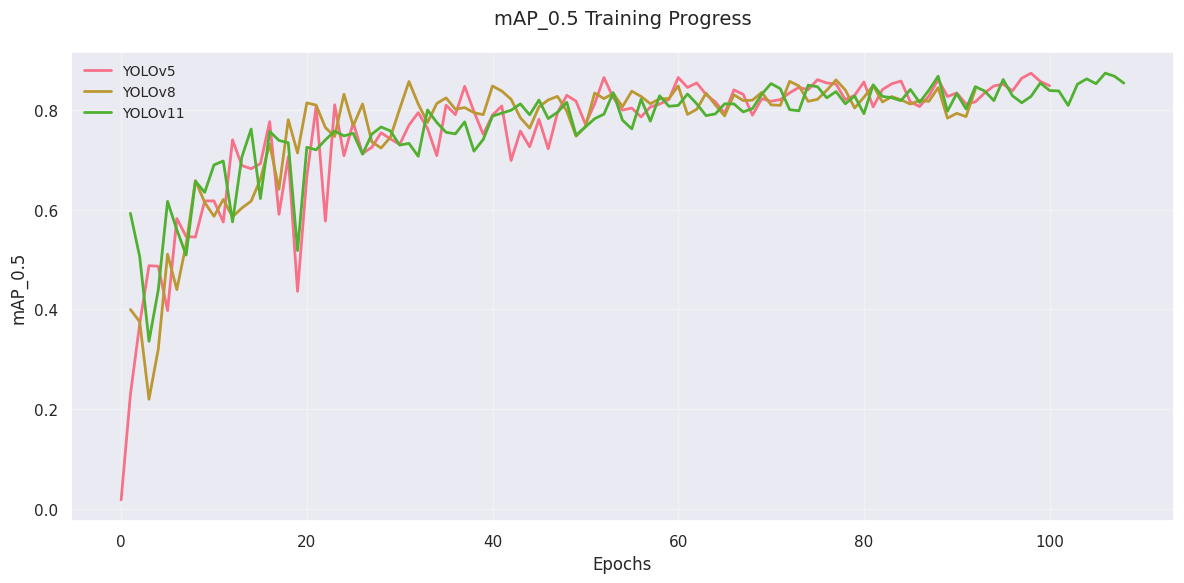

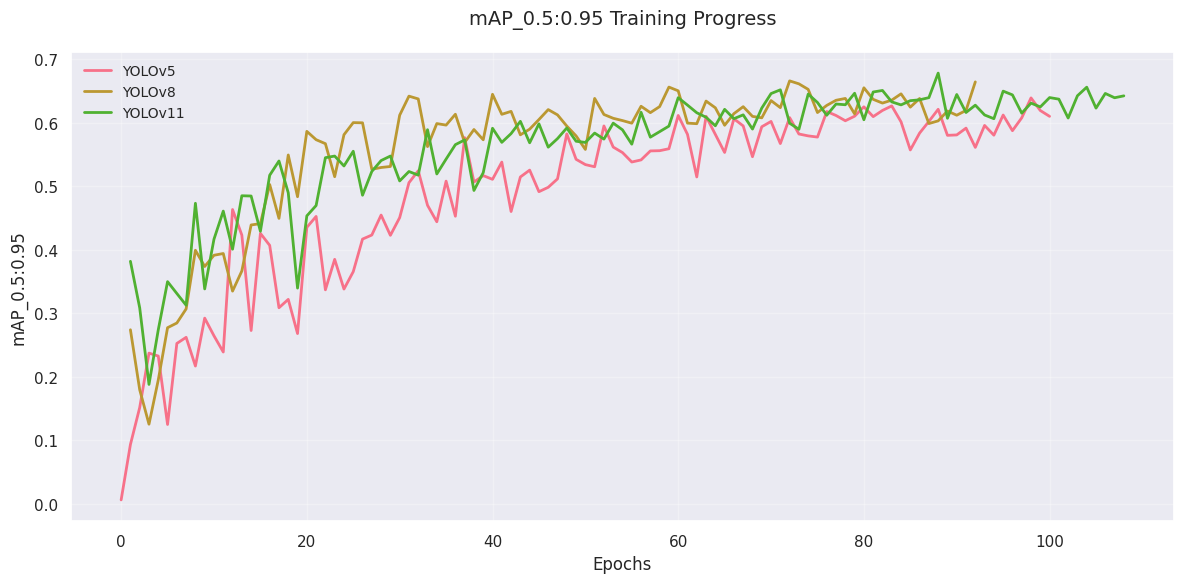

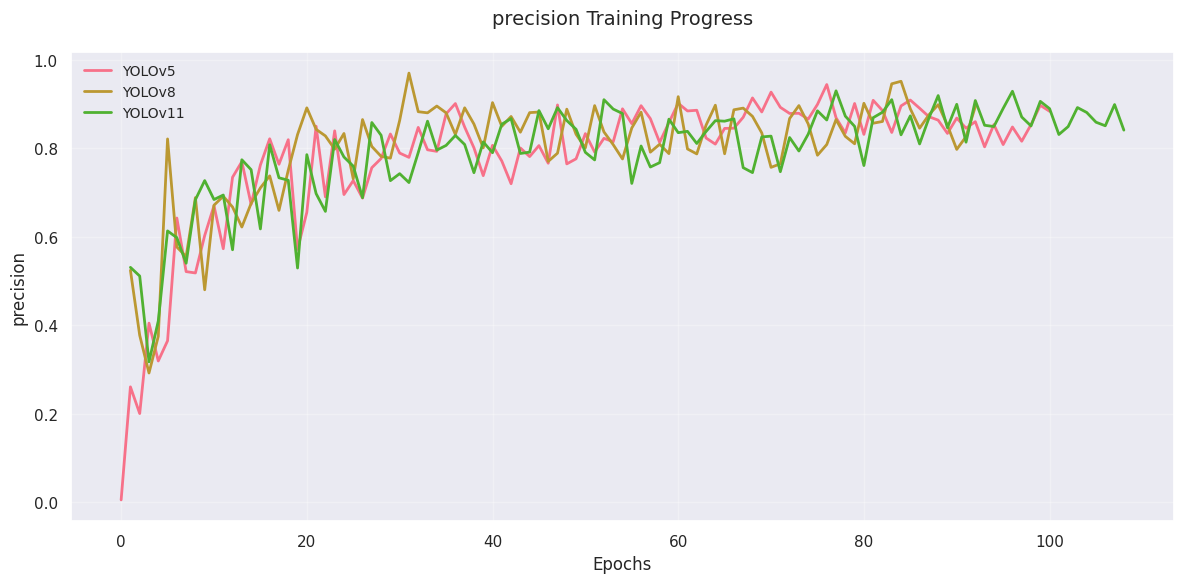

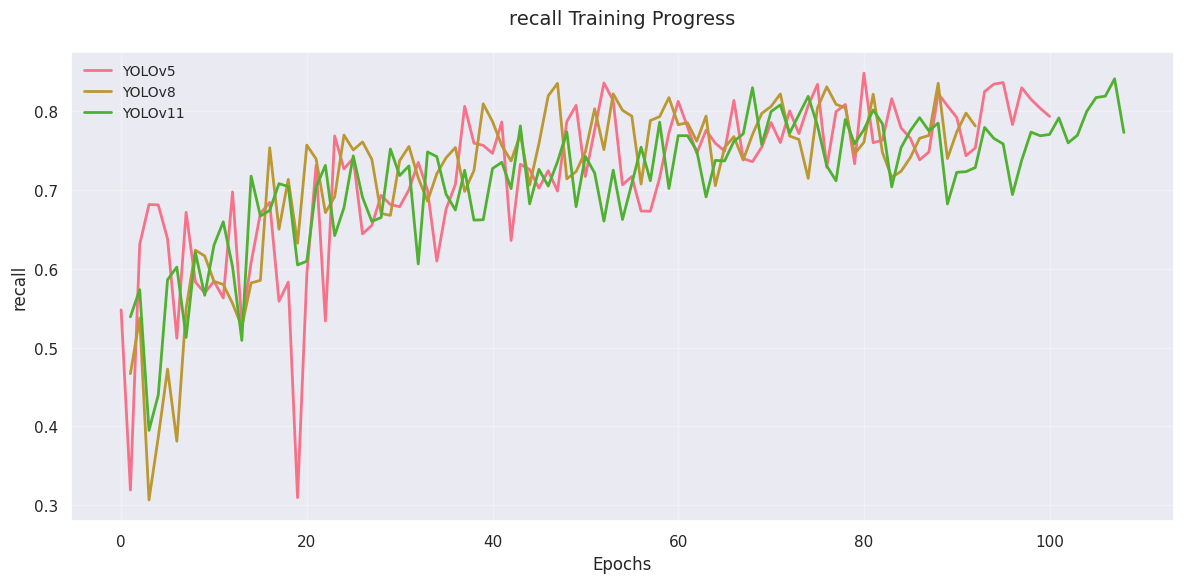

In [11]:
plot_training_metrics(models_results, metrics_mapping)

In [17]:
# performance comparison
metrics_df = create_performance_table(models_results, metrics_mapping)
display(metrics_df)


Best Performance Found at:
YOLOv5: Epoch 99
YOLOv8: Epoch 77
YOLOv11: Epoch 106

Best Overall mAP@0.5: 0.8750 (YOLOv11)


,YOLOv5,YOLOv8,YOLOv11
mAP@0.5,0.8748,0.8613,0.8750
mAP@0.5:0.95,0.6389,0.6352,0.6460
Precision,0.8533,0.8647,0.8507
Recall,0.8154,0.8091,0.8194
Best Epoch,99.0000,77.0000,106.0000


In [15]:
data_yaml_path = '/content/drive/MyDrive/evaluation/Garbage-Detection-4/data.yaml'
overall_results, per_class_metrics = evaluate_on_test_set(data_yaml_path)


Evaluating YOLOv8
Ultralytics 8.3.68 🚀 Python-3.11.11 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/drive/MyDrive/evaluation/Garbage-Detection-4/test/labels... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<00:00, 86.04it/s]


val: New cache created: /content/drive/MyDrive/evaluation/Garbage-Detection-4/test/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [01:26<00:00, 43.42s/it]


                   all         30         91      0.879      0.622      0.724      0.476
           Mixed Waste          9         16      0.897      0.875       0.85      0.558
         Organic Waste         11         39      0.919      0.564      0.785       0.53
           Other Waste          9         17          1      0.206      0.364      0.134
   Recyclable Material         10         19      0.698      0.842      0.899      0.681
Speed: 18.9ms preprocess, 2828.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Saving runs/detect/Test_Results_YOLOv8/predictions.json...
Results saved to runs/detect/Test_Results_YOLOv8

Evaluating YOLOv11
Ultralytics 8.3.68 🚀 Python-3.11.11 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11s summary (fused): 238 layers, 9,414,348 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/drive/MyDrive/evaluation/Garbage-Detection-4/test/labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:41<00:00, 20.98s/it]


                   all         30         91      0.741      0.696      0.738       0.51
           Mixed Waste          9         16      0.715      0.938      0.844      0.567
         Organic Waste         11         39          1      0.662      0.905      0.612
           Other Waste          9         17       0.53      0.235      0.266      0.143
   Recyclable Material         10         19       0.72      0.949      0.938      0.718
Speed: 22.6ms preprocess, 1342.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Saving runs/detect/Test_Results_YOLOv11/predictions.json...
Results saved to runs/detect/Test_Results_YOLOv11

Evaluating YOLOv5


YOLOv5 🚀 v7.0-397-gde62f93c Python-3.11.11 torch-2.3.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/drive/MyDrive/evaluation/Garbage-Detection-4/test/labels... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<00:00, 68.13it/s]
test: New cache created: /content/drive/MyDrive/evaluation/Garbage-Detection-4/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 1/1 [09:28<00:00, 568.17s/it]
                   all         30         91      0.665      0.721      0.726      0.497
           Mixed Waste         30         16      0.773      0.812      0.828      0.599
         Organic Waste         30         39      0.862      0.799      0.884      0.616
           Other Waste         30         17      0.364      0.271      0.257      0.121
   Recyclable Material         30         19      0.663          1      0.937      0.

Error evaluating YOLOv5: 'tuple' object has no attribute 'results_dict'


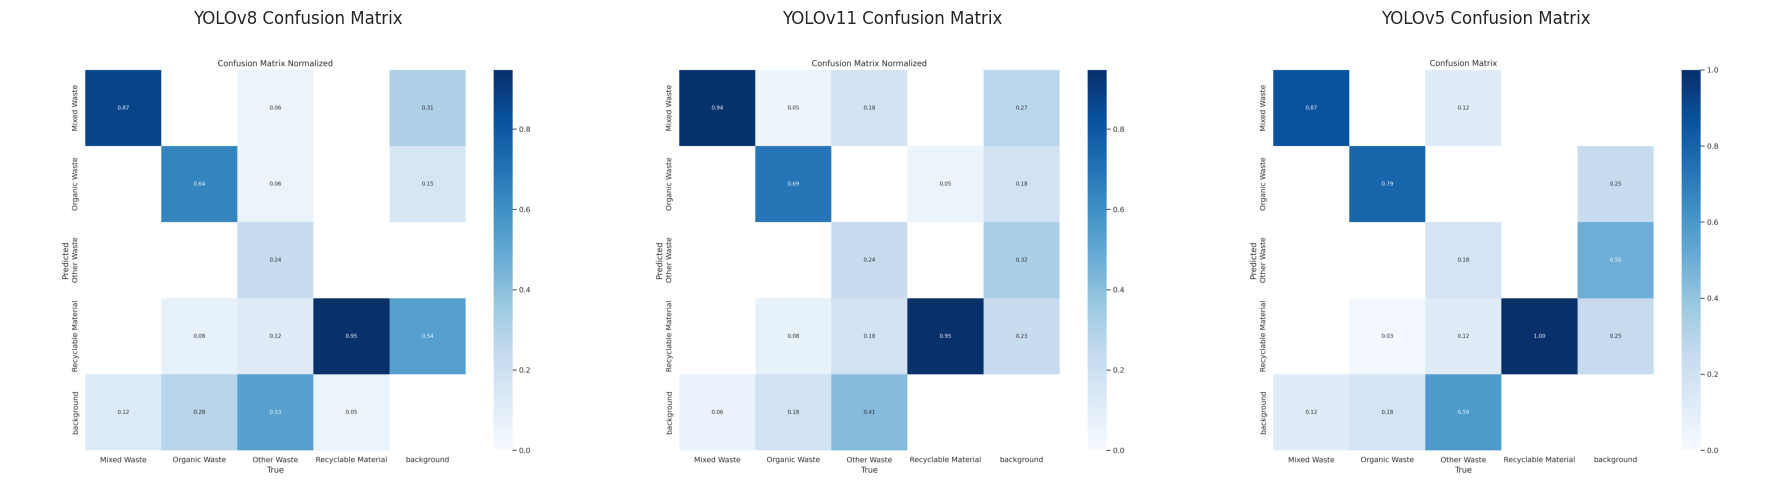

In [27]:
plot_confusion_matrices()